In [1]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report
from sktime.transformations.panel.rocket import MiniRocketMultivariate as minirocket
from sktime.transformations.panel.rocket import Rocket
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import RidgeClassifierCV as RC
from sklearn import metrics

In [2]:
# get relative indices
# manually entered via looking at 
#https://raw.githubusercontent.com/google/mediapipe/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules
#/face_geometry/data/canonical_face_model_uv_visualization.png

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
opath = "/Users/nraman/Documents/thesis_videos/"
# make sure to get 
subfolders = [i for i in os.listdir(opath) if ".mp4" not in i and ".DS_Store" not in i and ".MOV" not in i]

def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) > 1):
        return("Error: Multiple np arrays saved in the folder")
    else:
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [4]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]

ground_data = []
speak_data = []

for s in speak_folders:
    data = find_pointfolder(s)
    #if(len(data) < 40):
    speak_data.append(data)

s_lengths = [s.shape[0] for s in speak_data]

for g in ground_folders:
    ar_init = find_pointfolder(g)
    num_instances = ar_init.shape[0]
#     choice = np.random.randint(15, 30)
    
#     if(num_instances > 700):
#         splits = 2
#     else:
#         splits = 1
    
    #ground_data.extend(np.array_split(ar_init, splits))
    ground_data.append(ar_init)


In [5]:
lens = [g.shape[0] for g in ground_data] + [s.shape[0] for s in speak_data]
maxlen = max(lens)

In [6]:
# each input is list of arrays (each 2d, of dimension #timepoints x #points*2)--ground corresponds to no speech
# get dataframe of dimension #samples x #features
def timeseries_df(groundlist, speaklist, num_features = len(combo_indices)*2, const = 0, pd_mode = True):
    sz = len(groundlist) + len(speaklist)
    numspeak = len(speak_data)
    
    if(pd_mode == True):
        df = pd.DataFrame(np.zeros([sz, num_features])).astype(object)
    else:
        df = np.zeros((sz, num_features, maxlen))

    for j in range(sz):
        for a in range(len(combo_indices)*2):
            if(j < numspeak):
                cur = speaklist[j][:, a]
            else:
                it = j - numspeak
                cur = groundlist[it][:, a]
            if(pd_mode == True):
                df.iloc[j, a] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
            else:
                df[i, j] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
    
    true = np.concatenate([np.ones(numspeak), np.zeros(sz - numspeak)])
    
    return df, true

In [7]:
alldata, alltrue = timeseries_df(ground_data, speak_data)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(alldata, alltrue, test_size = 0.1, shuffle = True)

In [9]:
# # train Rocket embedding
rocket = minirocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [10]:
# # train logistic regression classifier
classifier = LR(max_iter = 500)
classifier.fit(X_train_transform, y_train)

LogisticRegression(max_iter=500)

In [11]:
X_test_transform = rocket.transform(X_test)
print(classifier.score(X_test_transform, y_test))
print(classifier.predict(X_test_transform))
print(y_test)


0.9090909090909091
[1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]


### STRANGE NOTE: 
When timeseries_df looks like the code below, I get classifier accuracies around 60%. However, when I change to cur[:window], I get around 90% accuracy!
         

In [19]:
kf = KFold(n_splits=10)
kf.get_n_splits(X = alldata, y = alltrue)

preds = []
actual = []

for train_index, test_index in tqdm(kf.split(alldata)):
    X_train, X_test = alldata.iloc[train_index,:], alldata.iloc[test_index,:]
    y_train, y_test = alltrue[train_index], alltrue[test_index]
    
    rocket = minirocket()
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)
    
    model = LR(max_iter = 10000)
    model.fit(X_train_transform, y_train)
    
    pred_values = model.predict(rocket.transform(X_test))
    preds.append([int(i) for i in pred_values])
    actual.append([int(i) for i in y_test])

10it [00:10,  1.04s/it]


In [20]:
allpreds = np.concatenate(preds)
allactual = np.concatenate(actual)

print(classification_report(allactual, allpreds, target_names=["Non-Speech", "Speech"]))


              precision    recall  f1-score   support

  Non-Speech       0.81      0.60      0.69        43
      Speech       0.75      0.90      0.82        58

    accuracy                           0.77       101
   macro avg       0.78      0.75      0.76       101
weighted avg       0.78      0.77      0.77       101



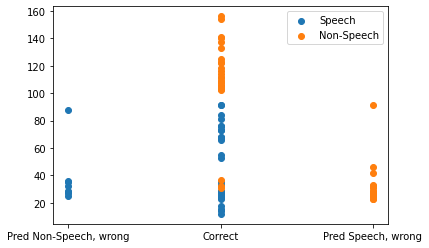

In [14]:
diffs = allpreds-allactual
plt.scatter(diffs[:len(s_lengths)], np.array(s_lengths), label = "Speech")
plt.scatter(diffs[len(s_lengths):], np.array([g.shape[0] for g in ground_data]), label = "Non-Speech")
plt.xticks([-1, 0, 1], labels = ["Pred Non-Speech, wrong", "Correct", "Pred Speech, wrong"])
plt.legend()
plt.show()

In [15]:
c = metrics.confusion_matrix(allactual, allpreds)
print("Confusion Matrix: " + str(c))
print("False rejection rate: " + str(c[1, 0]/np.sum(c)))

Confusion Matrix: [[25 18]
 [ 8 50]]
False rejection rate: 0.07920792079207921


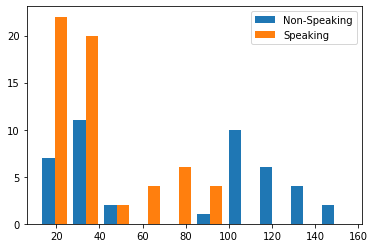

In [16]:
a = [g.shape[0] for g in ground_data]
b = [s.shape[0] for s in speak_data]

plt.hist([a, b], label = ["Non-Speaking", "Speaking"])
plt.legend()
plt.show()